In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import ttest_ind
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import re
import joblib


In [2]:
from IPython.display import HTML, display
def set_css():
 display(HTML('''
 <style>
 pre {
 white-space: pre-wrap;
 }
 </style>
 '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
import io
import requests
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:

df = pd.read_csv('/content/gdrive/MyDrive/T&I a3/review_data.csv')


contractions = {
    "can't": "cannot",
    "won't": "will not",
    "don't": "do not",
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "we're": "we are",
    "they're": "they are",
    "isn't": "is not",
    "aren't": "are not"
}

In [26]:

def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

df['cleaned_review'] = df['reviewText'].apply(clean_text)

In [6]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [33]:
print(df.isnull().sum())

Unnamed: 0.1        0
Unnamed: 0          0
asin                0
helpful             0
rating              0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName       38
summary             0
unixReviewTime      0
cleaned_review      0
sentiment           0
review_length       0
sentiment_class     0
dtype: int64


In [25]:

df['cleaned_review'] = df['reviewText'].apply(clean_text)


sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_review'].apply(lambda x: sid.polarity_scores(x)['compound'])

print(df['sentiment'])

0        0.8307
1        0.9628
2        0.8555
3        0.1531
4        0.4404
          ...  
11995    0.8020
11996    0.9581
11997    0.0644
11998   -0.7089
11999    0.8654
Name: sentiment, Length: 12000, dtype: float64


In [32]:

df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
print(df['review_length'])




0        522
1         63
2         75
3         54
4         20
        ... 
11995     26
11996    110
11997     72
11998     27
11999     97
Name: review_length, Length: 12000, dtype: int64


In [31]:
vectorizer = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['cleaned_review']).toarray()

In [29]:
def classify_sentiment(score):
    if score > 0.1:
        return 1
    elif score < -0.1:
        return 0
    else:
        return 2



In [28]:
df['sentiment_class'] = df['sentiment'].apply(classify_sentiment)
y = df['sentiment_class'].values
print(df['sentiment_class'])

0        1
1        1
2        1
3        1
4        1
        ..
11995    1
11996    1
11997    2
11998    0
11999    1
Name: sentiment_class, Length: 12000, dtype: int64


In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:

rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.21      0.33       670
           1       0.81      0.99      0.89      2797
           2       0.00      0.00      0.00       133

    accuracy                           0.81      3600
   macro avg       0.54      0.40      0.41      3600
weighted avg       0.78      0.81      0.75      3600



In [13]:

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.43      0.55       670
           1       0.84      0.97      0.90      2797
           2       0.00      0.00      0.00       133

    accuracy                           0.83      3600
   macro avg       0.53      0.47      0.48      3600
weighted avg       0.79      0.83      0.80      3600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:

rf_cv_score = cross_val_score(rf_classifier, X, y, cv=5)
svm_cv_score = cross_val_score(svm_classifier, X, y, cv=5)
print("\nRandom Forest Cross-Validation Scores:", rf_cv_score)
print("SVM Cross-Validation Scores:", svm_cv_score)


Random Forest Cross-Validation Scores: [0.81083333 0.81833333 0.82208333 0.81166667 0.81416667]
SVM Cross-Validation Scores: [0.83166667 0.845      0.83875    0.83666667 0.83958333]


<ipython-input-15-2357949139e7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['sentiment'], bins=30)


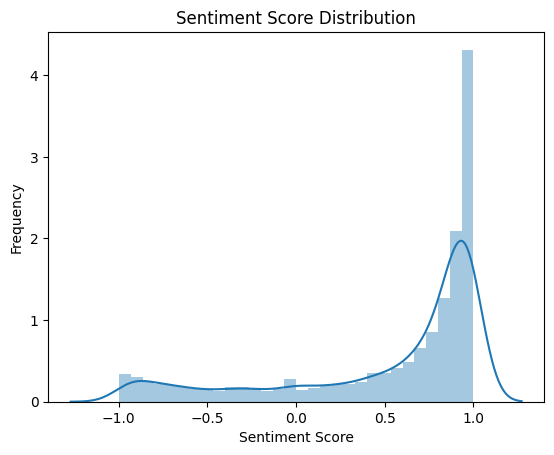

In [15]:

sns.distplot(df['sentiment'], bins=30)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


<ipython-input-16-fa7eb6f89d41>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['review_length'], bins=30)


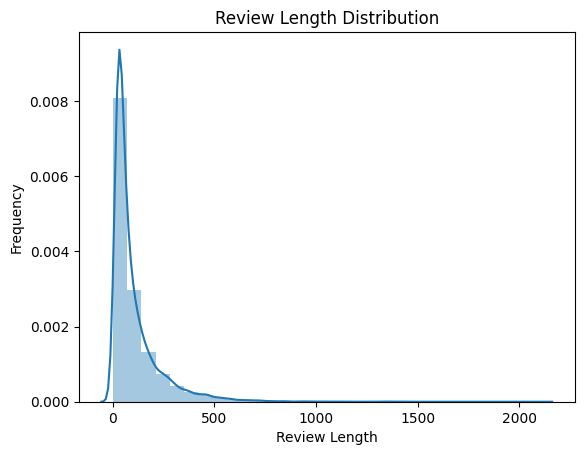

In [16]:

sns.distplot(df['review_length'], bins=30)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [17]:

correlation = df[['sentiment', 'review_length', 'rating']].corr()
print("Correlation Analysis:")
print(correlation)

Correlation Analysis:
               sentiment  review_length    rating
sentiment       1.000000       0.092850  0.419396
review_length   0.092850       1.000000  0.000477
rating          0.419396       0.000477  1.000000


In [18]:

positive_text = ' '.join(df[df['sentiment'] > 0]['cleaned_review'])
negative_text = ' '.join(df[df['sentiment'] <= 0]['cleaned_review'])

positive_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords.words('english'), min_font_size=10).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords.words('english'), min_font_size=10).generate(negative_text)


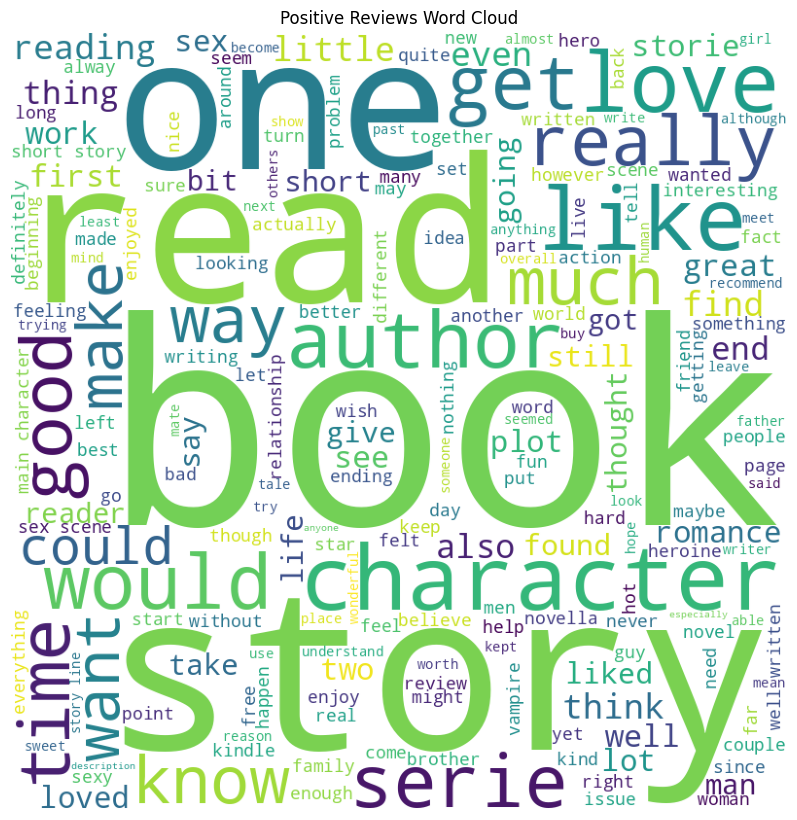

In [19]:

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(positive_wordcloud)
plt.title('Positive Reviews Word Cloud')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

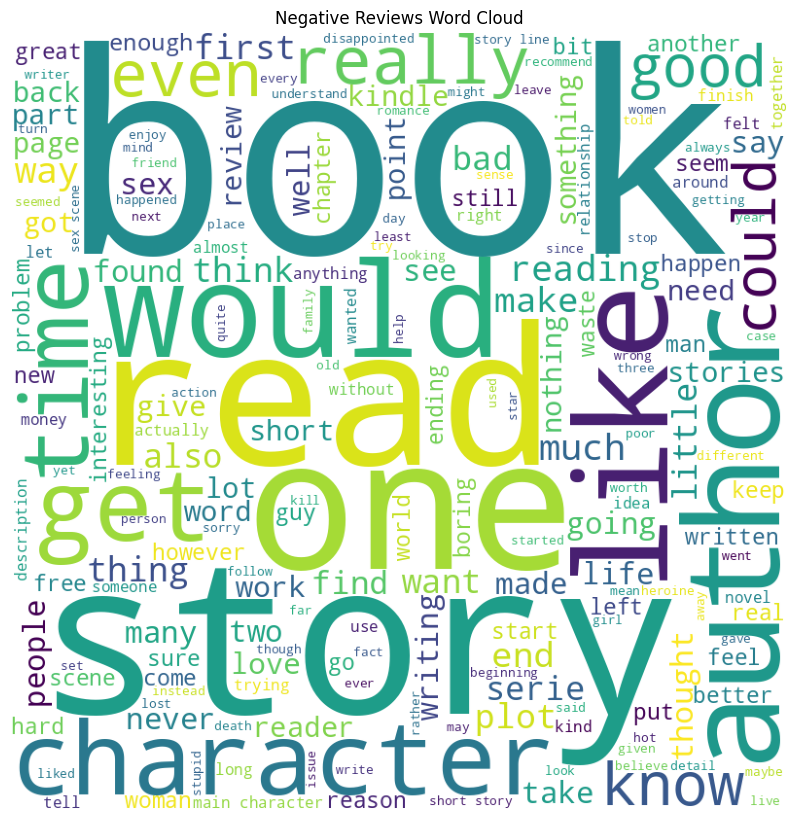

In [20]:

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(negative_wordcloud)
plt.title('Negative Reviews Word Cloud')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

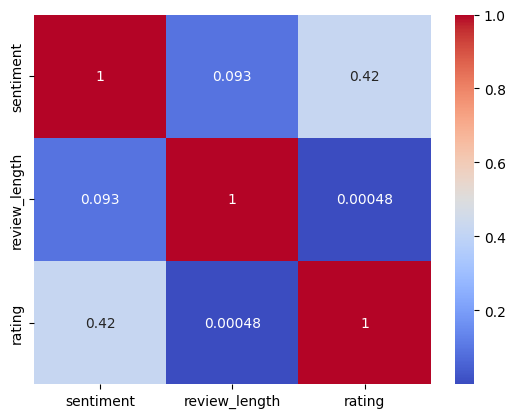

In [21]:

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

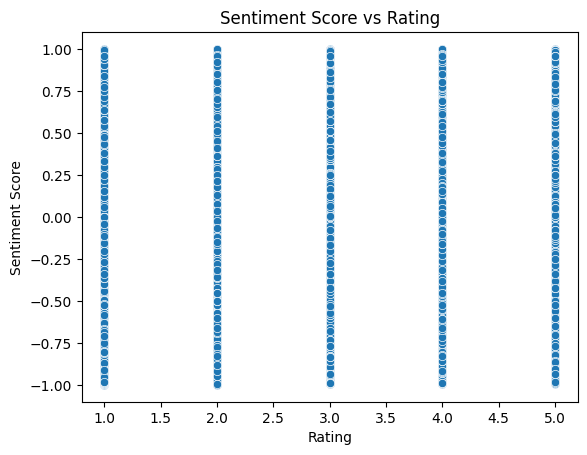

In [22]:

sns.scatterplot(data=df, x='rating', y='sentiment')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score vs Rating')
plt.show()

In [23]:

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [24]:

joblib.dump(svm_classifier, 'svm_sentiment_model.pkl')

['svm_sentiment_model.pkl']